# HW1

By:
1. Roni Roitbord (313575599)
2. Lior Yaacov Ben Ezra (__YOUR ID__)



### 1. Quantization

In [12]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

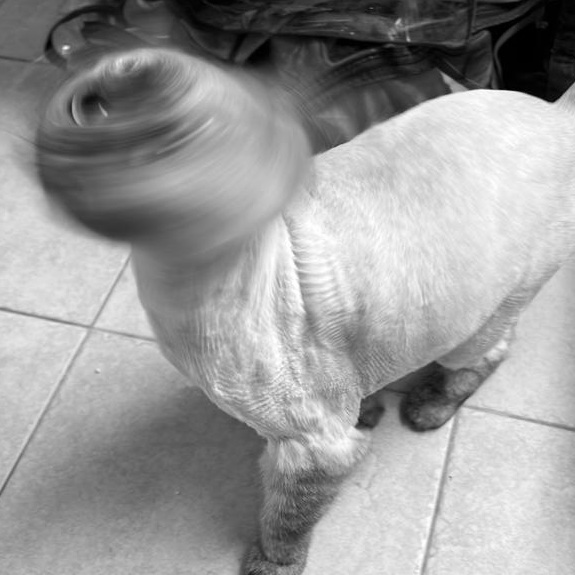

In [241]:
og_image = Image.open("./Drillocato.jpg")
gray_image = ImageOps.grayscale(og_image)
gray_image = gray_image.resize((575,575))
gray_image_arr = np.reshape(gray_image, gray_image.size[0] * gray_image.size[1])
display(gray_image)

### 1:
We would like to estimate the probability density function (pdf) of the gray levels
in the image using the image histogram. If the histogram seems too uniform, please
pick another image with a non-uniform distribution.

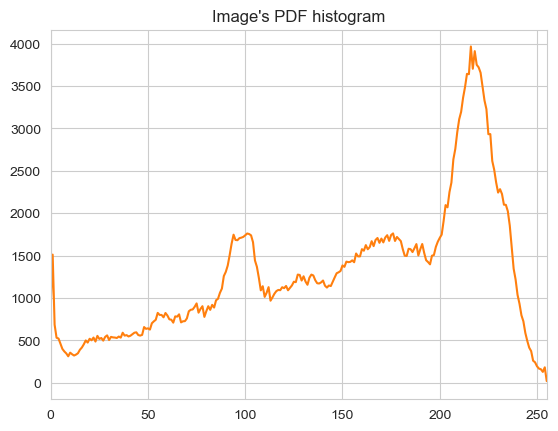

In [242]:
def calc_greyscale_hist(image):
    plt.plot(1,2)
    hist,bin = np.histogram(image,256,[0,255])
    plt.xlim([0,255])
    plt.plot(hist)
    plt.title("Image's PDF histogram")
    plt.show()

calc_greyscale_hist(gray_image)

We can see that the histogram does not represents a uniform distribution.

### 2:
 Apply uniform quantization on the image using b bits per pixel.
    a. Show the MSE as a function of the bit-budget b for b = 1, ..., 8.
    b. Plot the decision and representation levels for representative b values.

In [15]:
def uniform_quntizer(image_arr, bit):
    delta = (image_arr.max() - image_arr.min())/(2**bit)
    #Scaling
    unbiased_quantized_array = (np.floor((image_arr - image_arr.min())/delta)+0.5)*delta
    #biasing
    quantized_array = unbiased_quantized_array + image_arr.min()
    return quantized_array

#Calculte the MSE
def mse_on_grayscale(mse_array):
    bits = range(0,8)
    for i in bits:
        mse_array.append(np.mean((gray_image_arr - uniform_quntizer(gray_image_arr, i+1))**2))
    plt.plot(bits, mse_array)
    plt.title("MSE as a function of the bit-budget b")
    plt.xlabel("b")
    plt.ylabel("MSE")

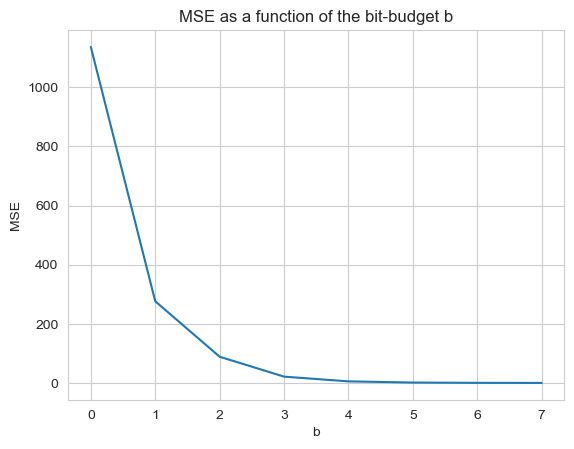

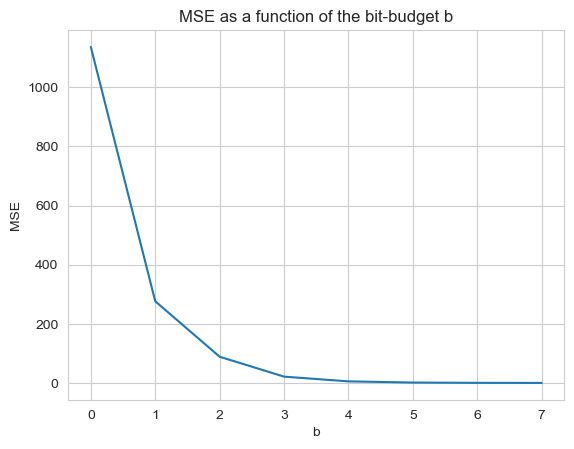

In [16]:
#quantized_image = uniform_quntizer(gray_image_arr, 5).reshape(gray_image.size[0],gray_image.size[1])
#plt.imshow(quantized_image, cmap='gray')
#plt.grid(None)
#plt.show()
mse_arr = []
mse_on_grayscale(mse_arr)

In [17]:
def get_levels(image_array, bit) :
    power_of_b = 2**bit
    decisions, representations = [],[]
    delta = (image_array.max() - image_array.min())/(power_of_b)
    for i in range(power_of_b+1) :
        decisions.append(image_array.min() + delta*i)
        if i != power_of_b-1:
            representations.append(image_array.min() + delta*(i+0.5))
    return decisions, representations

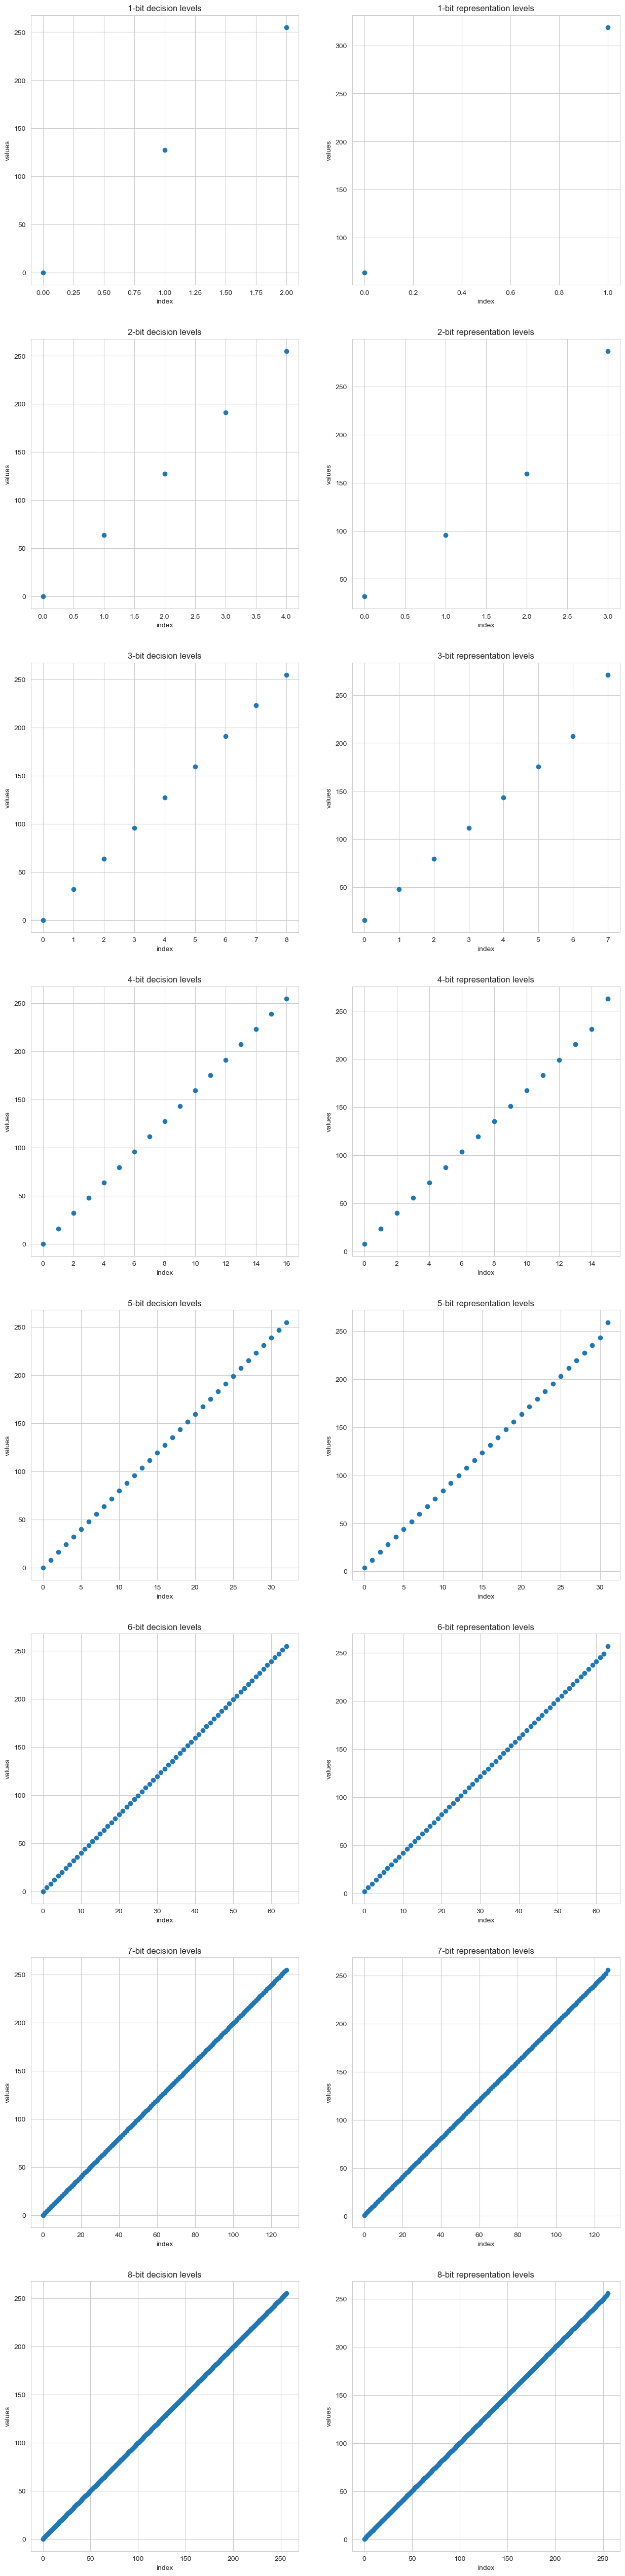

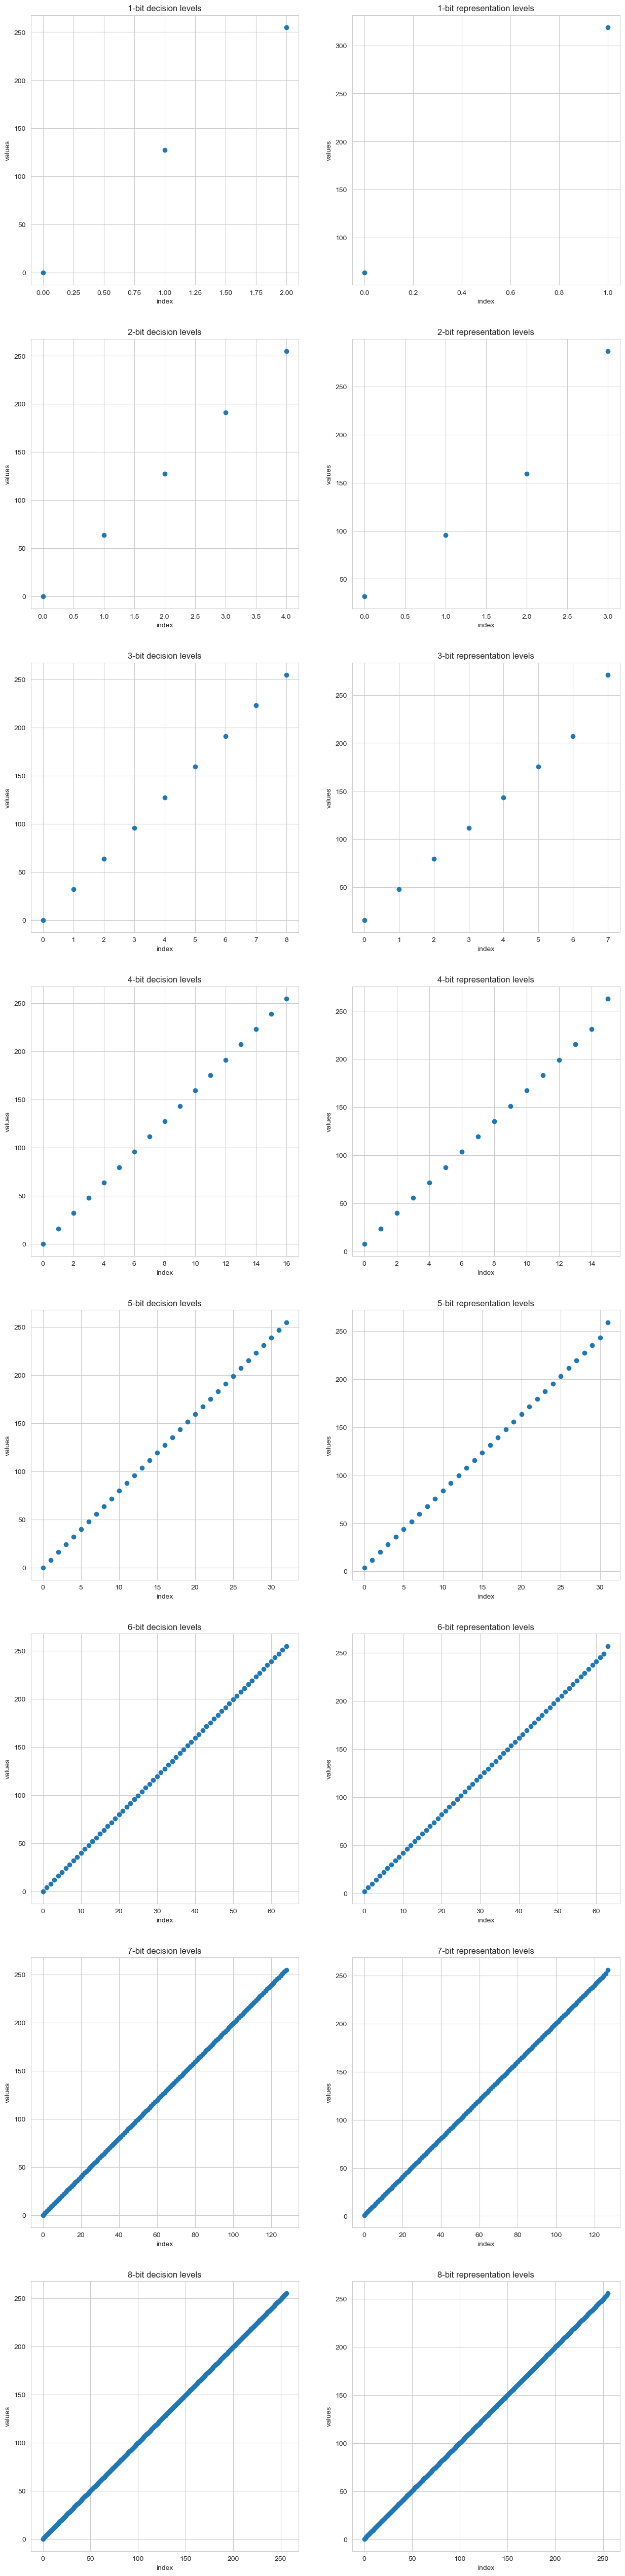

In [18]:
fig, axs = plt.subplots(8,2, figsize=(15, 65))
fig.subplots_adjust(hspace=0.2)
#fig.suptitle(title, fontsize=16, y=1.05)
axs = np.ravel(axs)

for i in range(8) :
    decisions, representations = get_levels(gray_image_arr, i+1)

    axs[2*i].plot(decisions, "o")
    axs[2*i].set_title(f"{i+1}-bit decision levels")
    axs[2*i].set_xlabel("index")
    axs[2*i].set_ylabel("values")

    axs[2*i+1].plot(representations, "o")
    axs[2*i+1].set_title(f"{i+1}-bit representation levels")
    axs[2*i+1].set_xlabel("index")
    axs[2*i+1].set_ylabel("values")
plt.show()

### 3:

Implement the Max-Lloyd algorithm. This should be a function taking as input
a histogram pdf, a vector of initial decision levels, and a small value ε > 0 for
convergence tolerance. The function should return the converged decision levels and
the converged representation levels. In order to handle numerical approximations,
we use ε as a stopping condition: when the MSE improves by less than ε we stop the
algorithm.

In [19]:
def calculate_decision(representations, decisions):
    for i in range(len(decisions) - 2):
        decisions[i+1] = (representations[i] + representations[i+1]) / 2
    return decisions

def calculate_representation(hist, decisions):
    num_decisions = len(decisions)
    x_px = np.array([x * hist[x] for x in range(hist.size)])
    representations = np.zeros(num_decisions - 1)
    for i in range(num_decisions-1):
        low_bound = np.ceil(decisions[i])
        high_bound = np.ceil(decisions[i + 1])
        hist_sum = np.sum(hist[int(low_bound):int(high_bound)])
        x_px_sum = np.sum(x_px[int(low_bound):int(high_bound)])
        if hist_sum == 0 or x_px_sum == 0:
            representations[i] = (decisions[i] + decisions[i + 1]) / 2
        else:
            representations[i] = x_px_sum / hist_sum
    return representations

def calculate_mse(hist, representation_levels, num_samples):
    squared_diff = np.square(representation_levels[:, np.newaxis] - np.arange(hist.size))
    weighted_squared_diff = hist * np.min(squared_diff, axis=0)
    mse = np.sum(weighted_squared_diff) / num_samples
    return mse

def maxloyd(hist, decision_levels, epsilon):
    num_samples = np.sum(hist)
    representations = calculate_representation(hist, decision_levels)
    old_mse = calculate_mse(hist, representations, num_samples)
    new_decisions = np.copy(decision_levels)
    while True:
        new_decisions = calculate_decision(representations, new_decisions)
        representations = calculate_representation(hist, new_decisions)
        mse = calculate_mse(hist, representations, num_samples)
        if np.abs(mse - old_mse) < epsilon:
            return new_decisions, representation, mse
        old_mse = mse

4. Apply the Max-Lloyd quantizer starting with uniform quantization.

a. Show the MSE as a function of the bit-budget b for b = 1, ..., 8.
b. Plot the decision and representation levels for representative b values.
c. Compare the results to those of the uniform quantizer. Explain the differences.

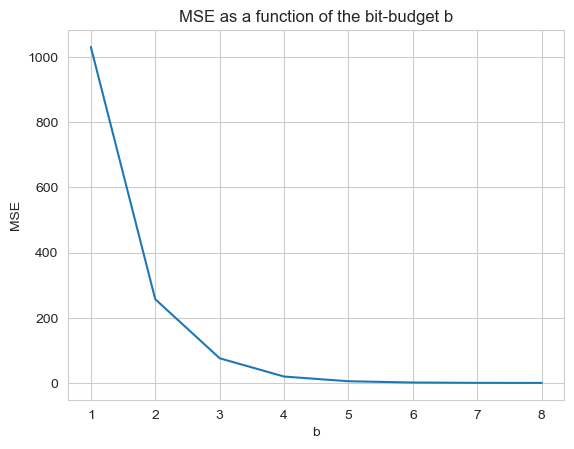

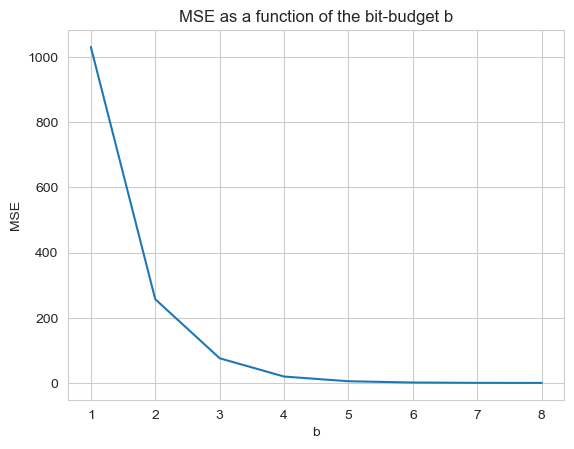

In [20]:
mse_arr_maxloyd = np.zeros(8)
hist = np.histogram(gray_image_arr, bins=range(257))
for i in range(8) :
    decision, representation = get_levels(gray_image_arr,i+1)
    decision, representation, mse = maxloyd(hist[0], decision, 0.1)
    mse_arr_maxloyd[i] = mse

plt.plot(range(1,9), mse_arr_maxloyd)
plt.title("MSE as a function of the bit-budget b")
plt.xlabel("b")
plt.ylabel("MSE")
plt.show()

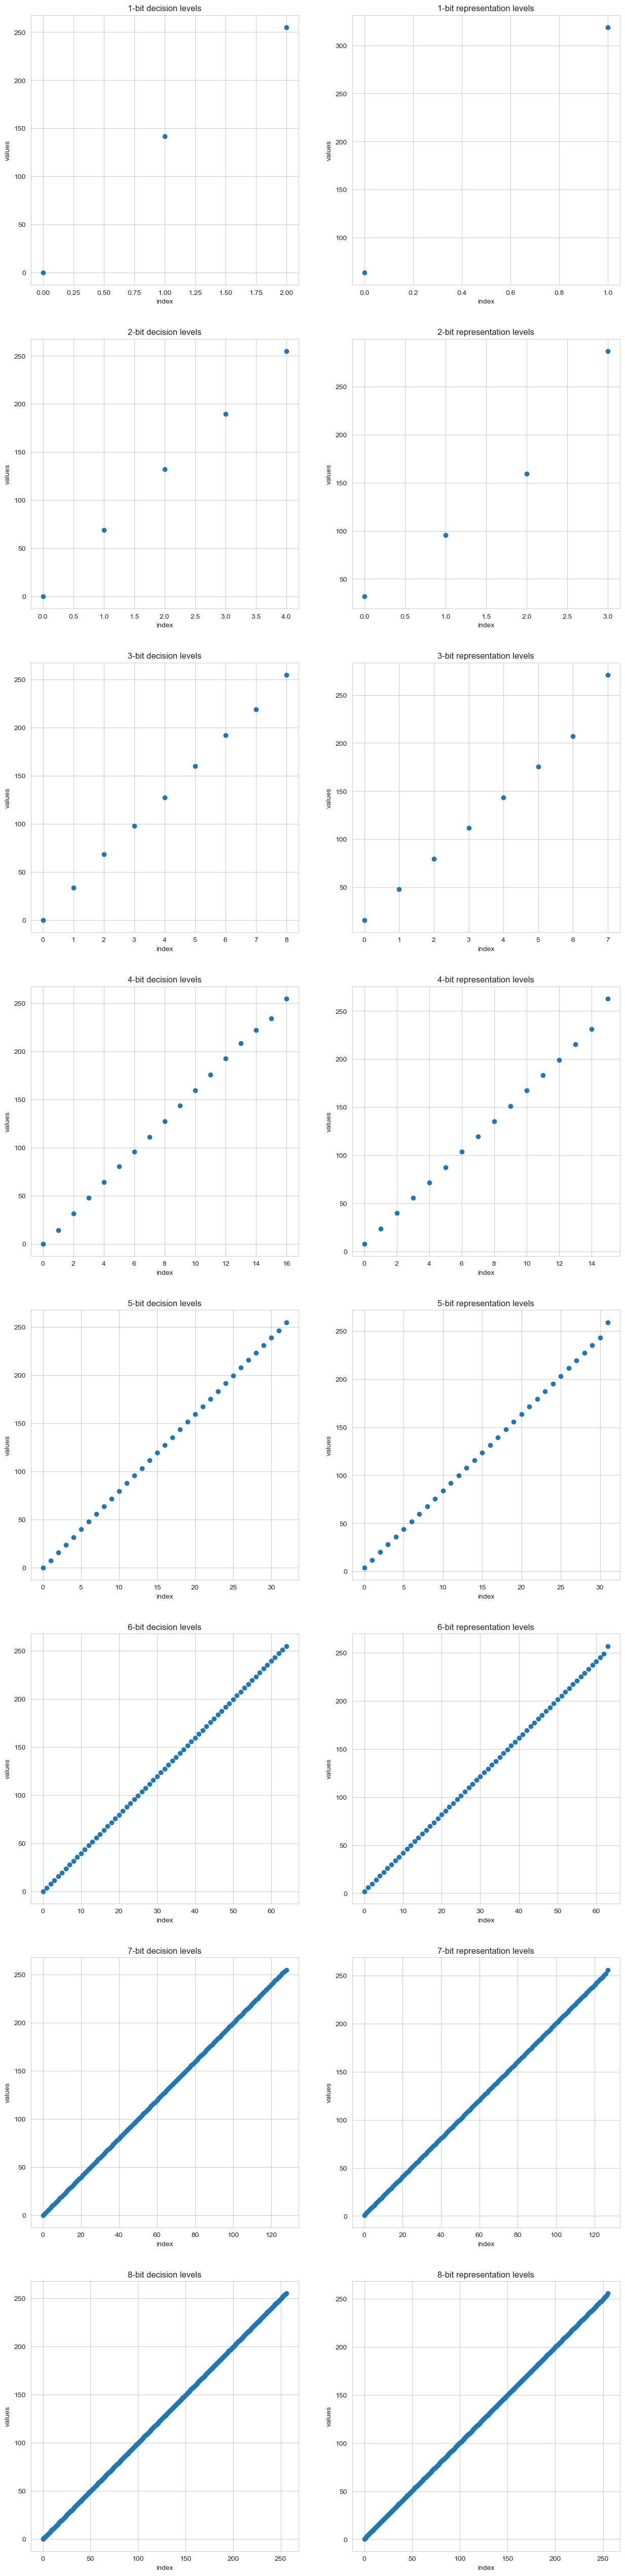

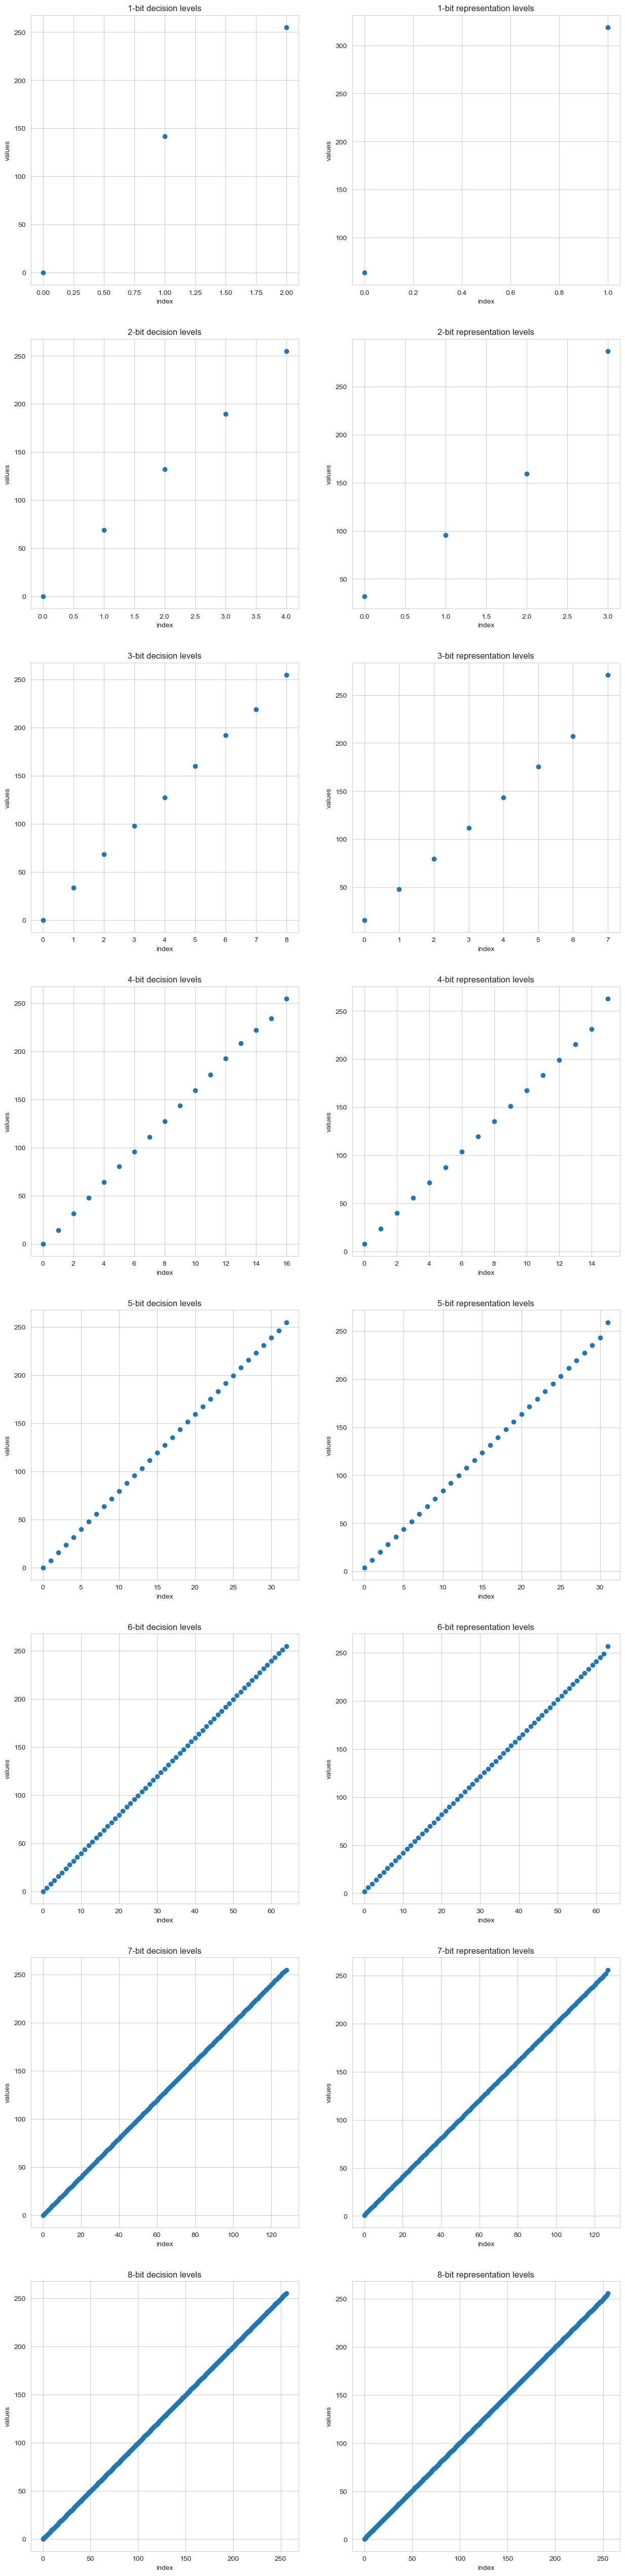

In [21]:
fig, axs = plt.subplots(8,2, figsize=(15, 65))
fig.subplots_adjust(hspace=0.2)
axs = np.ravel(axs)

for i in range(8) :
    decision, representation = get_levels(gray_image_arr,i+1)
    decision, representation, mse = maxloyd(hist[0], decision, 0.1)

    axs[2*i].plot(decision, "o")
    axs[2*i].set_title(f"{i+1}-bit decision levels")
    axs[2*i].set_xlabel("index")
    axs[2*i].set_ylabel("values")

    axs[2*i+1].plot(representation, "o")
    axs[2*i+1].set_title(f"{i+1}-bit representation levels")
    axs[2*i+1].set_xlabel("index")
    axs[2*i+1].set_ylabel("values")
plt.show()

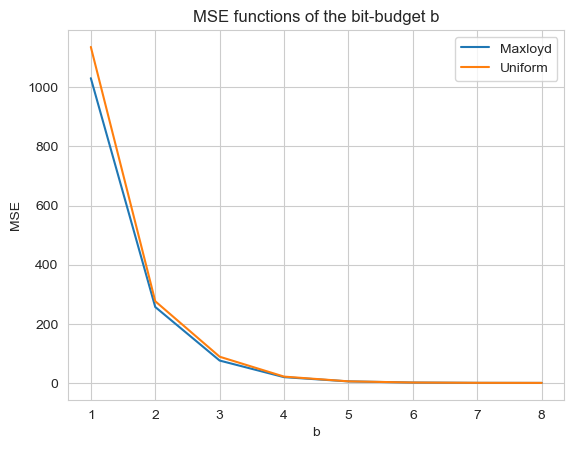

In [24]:
ml_plt, = plt.plot(range(1,9), mse_arr_maxloyd, label = 'Maxloyd')
uni_plt, = plt.plot(range(1,9), mse_arr, label = 'Uniform')
plt.legend(handles = [ml_plt, uni_plt])
plt.title("MSE functions of the bit-budget b")
plt.xlabel("b")
plt.ylabel("MSE")
plt.show()

### 3. Solving the $L^p$ problem using the $L^2$ solution

2. Implement this algorithm by a function with inputs f, N, and ε > 0.

In [344]:
def lp_solver(gray_img, N, p, epsilon, delta):
    img_sample = np.zeros((N,N))
    scale = gray_img.shape[0]//N
    # Because of uniform distribution, the first error will be just the mean over the image by the power of p
    old_lp_error = np.mean((gray_img)**p)
    # The reason for the infinite loop is that for each parameter, the number of iterations may vary
    while True:
        total_lp_error = 0
        for i in range(N):
            for j in range(N):
                scale_i = i*scale
                scale_j = j*scale
                # Calculating new weights and intervals
                w = (np.abs(gray_img[scale_i:scale_i+scale,scale_j:scale_j+scale]-img_sample[i][j]))**(p-2)
                w = np.minimum(w, np.array(1/epsilon))
                scaled_img = gray_img[scale_i:scale_i+scale,scale_j:scale_j+scale]
                interval = scaled_img*w
                img_sample[i][j]=delta if np.sum(w)<delta else np.sum(interval)/(np.sum(w))
                total_lp_error += np.sum((np.abs(scaled_img-img_sample[i][j]))**(p))
        new_lp_error = total_lp_error/(gray_img.size**2)
        if(np.abs(new_lp_error - old_lp_error) < delta):
            # Achieving the threshold, returning results
            return img_sample, new_lp_error
        old_lp_error = new_lp_error

3. Implement another function that solves the $L^1$ problem without approximation and
without using this algorithm.

In [345]:
def l1_solver(gray_img, N):
     img_sample = np.zeros((N,N))
     scale = gray_img.shape[0]//N
     total_l1_error = 0
     for i in range(N):
         for j in range(N):
             scale_i, scale_j = i*scale, j*scale
             scaled_img = gray_img[scale_i:scale_i+scale,scale_j:scale_j+scale]
             # According to lectures, median is the optimal value for p=1
             img_sample[i][j] = np.median(scaled_img)
             total_l1_error += np.sum((np.abs(scaled_img-img_sample[i][j])))
     total_l1_error = total_l1_error/(gray_img.size**(2))
     return img_sample , total_l1_error

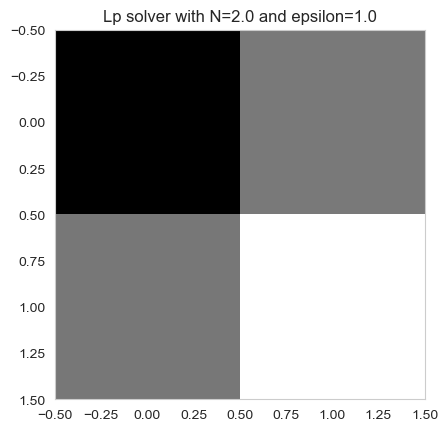

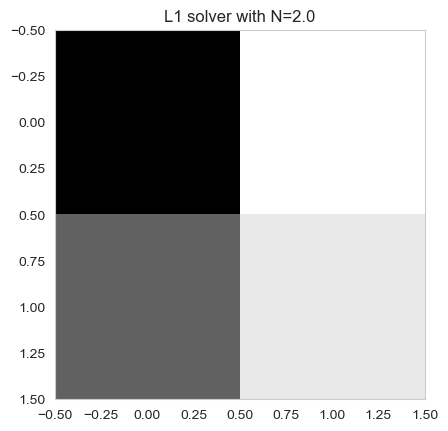

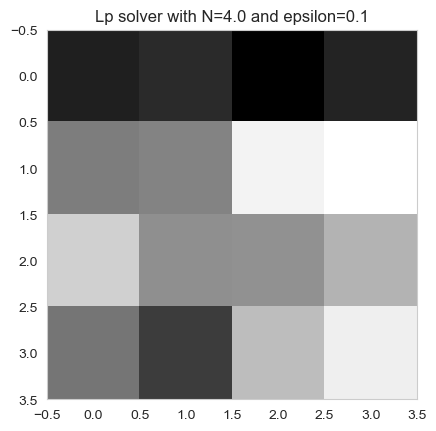

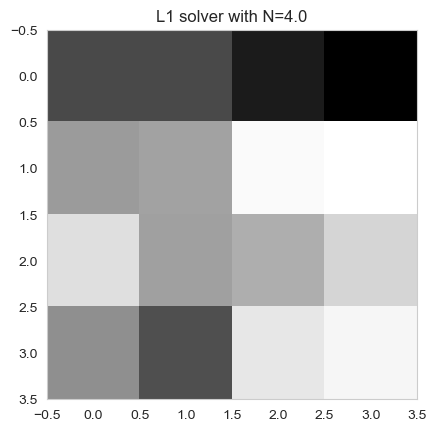

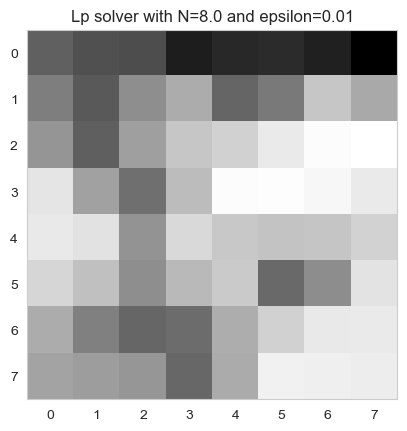

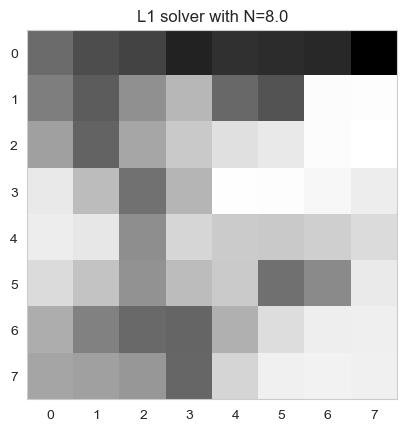

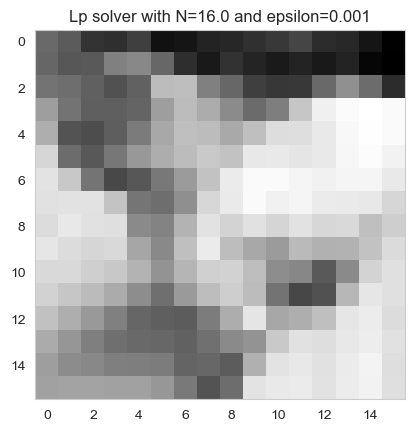

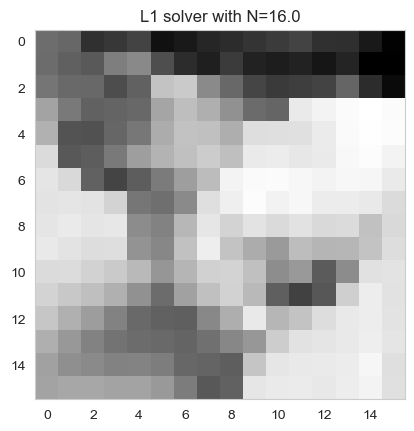

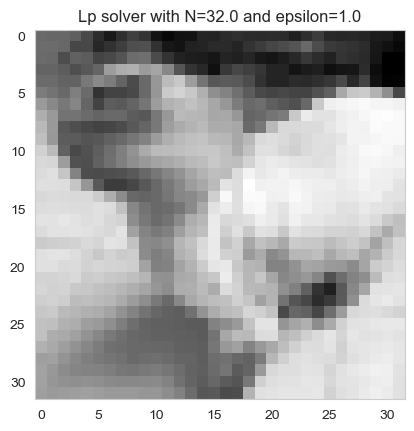

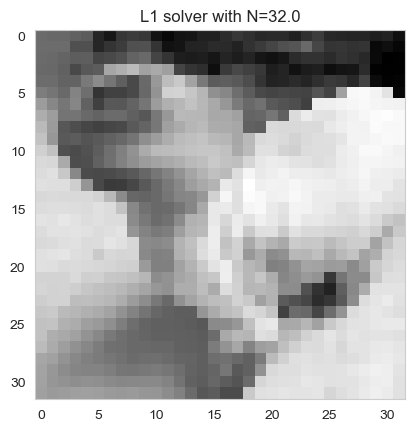

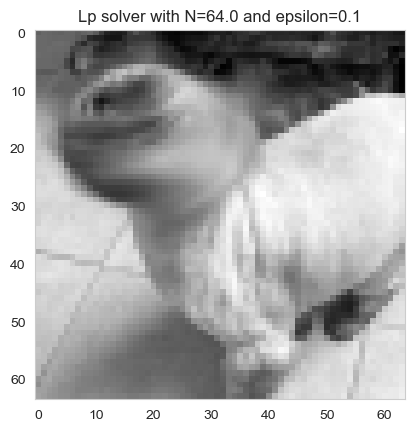

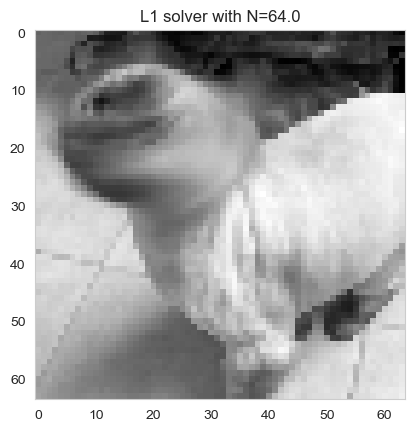

KeyboardInterrupt: 

In [346]:
error_array=np.zeros((8,8))
l1_error_array=np.zeros(8)
gray_image_float=np.array(gray_image)
epsilons = np.logspace(0,-3,num=4,base=10)
epsilons = np.append(epsilons,epsilons)
for i,N in enumerate(np.logspace(1,8, num=8, base=2)):
    for j,epsilon in enumerate(epsilons):
        sampled_img, error=lp_solver(gray_image_float,int(N),2,epsilon,0.001)
        error_array[i][j]=error
        if i==j:
            plt.imshow(sampled_img, cmap='gray')
            plt.grid(False)
            plt.title(f"Lp solver with N={N} and epsilon={epsilon}")
            plt.show()
    l1_sampled_img, l1_error=l1_solver(gray_image_float,int(N))
    plt.imshow(l1_sampled_img, cmap='gray')
    plt.grid(False)
    plt.title(f"L1 solver with N={N}")
    plt.show()
    l1_error_array[i]=l1_error

5. Run your algorithm on the same image to compute the approximate $L^{1.5}$ and $L^4$ solutions. Comment on your results.

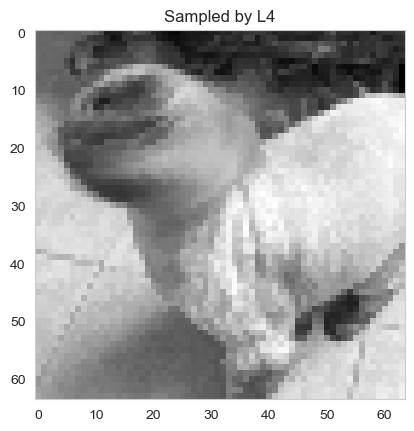

/var/folders/x3/fcjjxsd536j13wjtvmqc_hl00000gn/T/ipykernel_35499/817791739.py:13: RuntimeWarning: divide by zero encountered in power
  w = (np.abs(gray_img[scale_i:scale_i+scale,scale_j:scale_j+scale]-img_sample[i][j]))**(p-2)


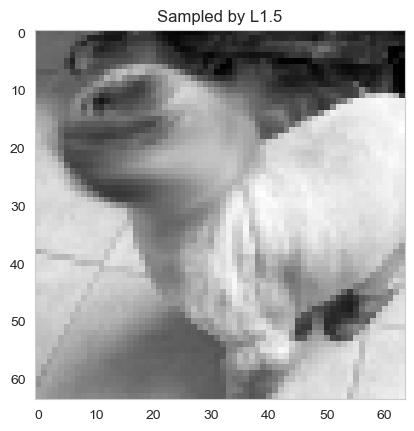

The error for l4 sampling is 0.8931895424712215
The error for l3/2 sampling is 6.194198659534119e-05


In [348]:
sampled_img_l4, l4_error=lp_solver(gray_image_float,64,4,0.001,0.01)
plt.imshow(sampled_img_l4, cmap='gray')
plt.title("Sampled by L4")
plt.grid(False)
plt.show()

sampled_img_l1dot5, l1dot5_error=lp_solver(gray_image_float,64,1.5,0.001,0.01)
plt.imshow(sampled_img_l1dot5, cmap='gray')
plt.title("Sampled by L1.5")
plt.grid(False)
plt.show()

print(f"The error for l4 sampling is {l4_error}")
print(f"The error for l3/2 sampling is {l1dot5_error}")

### 2.  BONUS: Subsampling and Reconstruction

a. In the MSE sense, present the sub-sampled image for all different D. Denote these sub-sampled images by ${(J_i)^8}_{i=1}$
Show the MSE as a function of the integer sub-sampling factor D.

In [408]:
def image_constructor(gray_img, N, is_mse):
    grid_gray_image = np.zeros((N, N))
    scale = gray_img.shape[0]//N
    norm_func = np.mean if is_mse else np.median
    for i in range(N):
        for j in range(N):
            scale_i, scale_j = i*scale, j*scale
            scaled_img = gray_img[scale_i:scale_i+scale,scale_j:scale_j+scale]
            grid_gray_image[i][j]= norm_func(scaled_img)+0.5
    orig_N = gray_image_float.shape[0]
    reconstructed_image = np.zeros((orig_N,orig_N))
    scale = orig_N//N
    for i in range(N):
        for j in range(N):
            scale_i, scale_j = i*scale, j*scale
            reconstructed_image[scale_i:scale_i+scale,scale_j:scale_j+scale] = grid_gray_image[i][j]
    return grid_gray_image, reconstructed_image

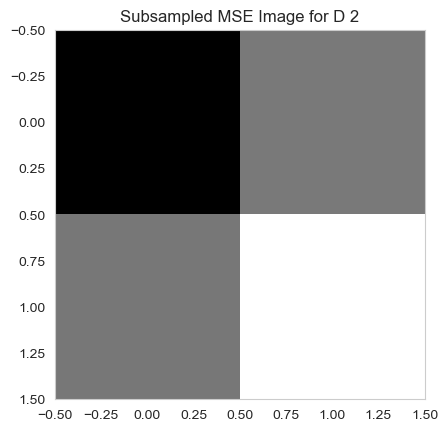

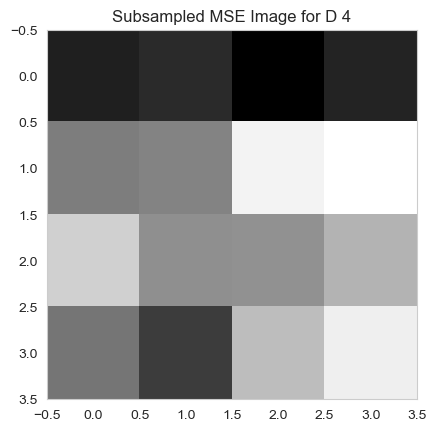

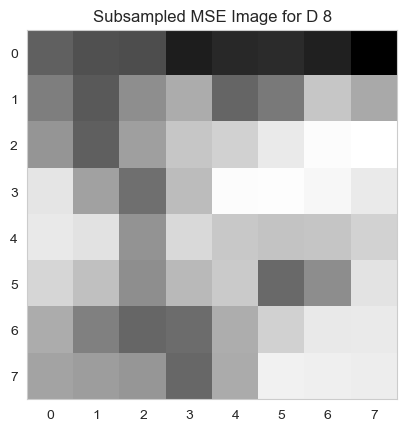

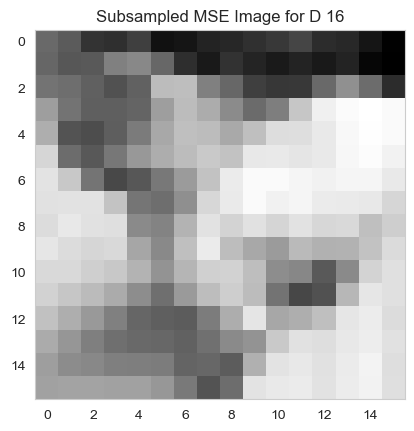

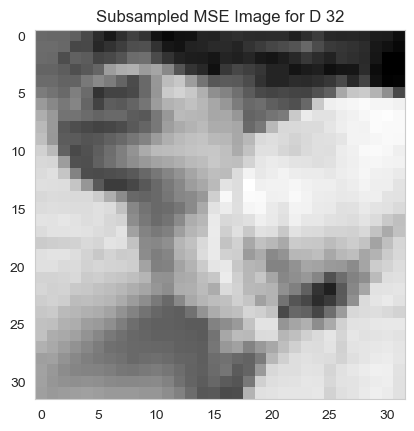

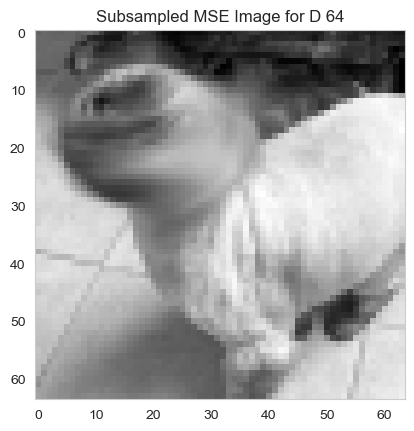

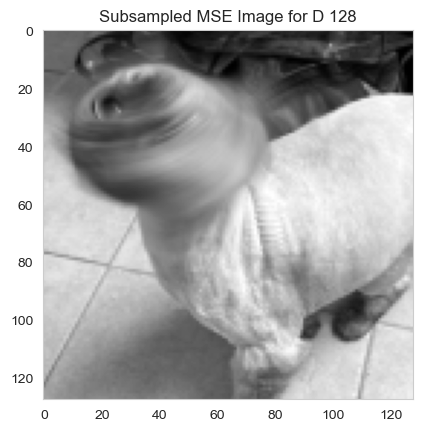

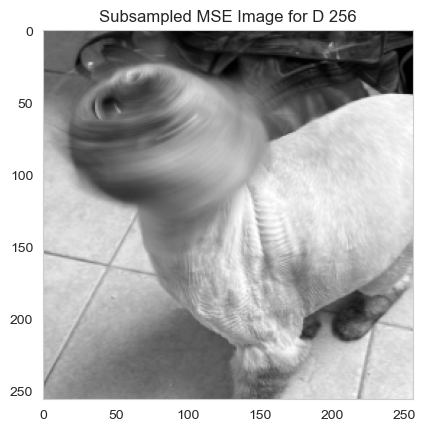

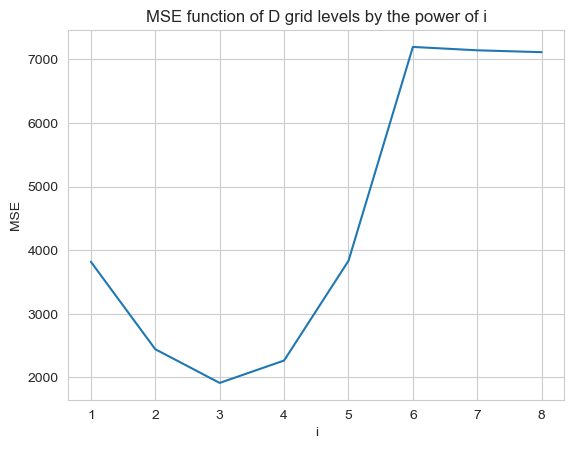

In [409]:
mse_array = np.zeros(8)
mse_reconstructed_image = []
for i in range(8):
    sampled_image, rec_img = image_constructor(gray_image_float, 2**(i+1), True)
    mse_reconstructed_image.append(rec_img)
    mse_array[i] = np.mean((gray_image_float - rec_img)**2)
    plt.title(f"Subsampled image for D={2**(i+1)}")
    plt.imshow(sampled_image, cmap='gray')
    plt.grid(False)
    plt.show()

plt.title("MSE function of D grid levels by the power of i")
plt.xlabel("i")
plt.ylabel("MSE")
plt.plot(np.arange(1,9,1),mse_array)
plt.show()

b. In the MAD sense, present the sub-sampled image for all different D. Denote these sub-sampled images by ${(J_i)^8}_{i=1}$ Show the NAD as a function of the integer sub-sampling factor D.

In [407]:
mad_array = np.zeros(8)
mad_reconstructed_images = []
for i in range(8):
    sampled_image, rec_img = image_constructor(gray_image_float, 2**(i+1), False)
    mad_reconstructed_images.append(rec_img)
    mad_array[i] = np.mean(np.abs(gray_image_float - rec_img))
    plt.title(f"Subsampled image for D={2**(i+1)}")
    plt.imshow(sampled_image, cmap='gray')
    plt.grid(False)
    plt.show()

plt.title("MAD function of D grid levels by the power of i")
plt.xlabel("i")
plt.ylabel("MAD")
plt.plot(np.arange(1,9,1),mad_array)
plt.show()

2. Reconstruct in the standard way ${(J˜_i)^8}_{i=1}$ and ${(J`_i)^8}_{i=1}$ back to the same size of the
original image, denoted by ${(K˜_i)^8}_{i=1}$ and ${(K`_i)^8}_{i=1}$. Present ${(K˜_i)^8}_{i=1}$ and ${(K`_i)^8}_{i=1}$

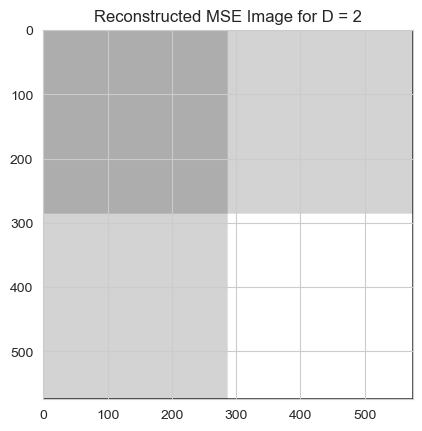

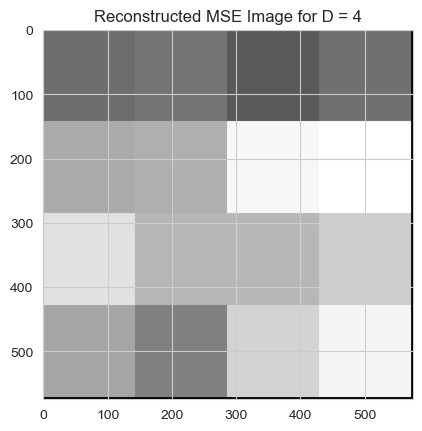

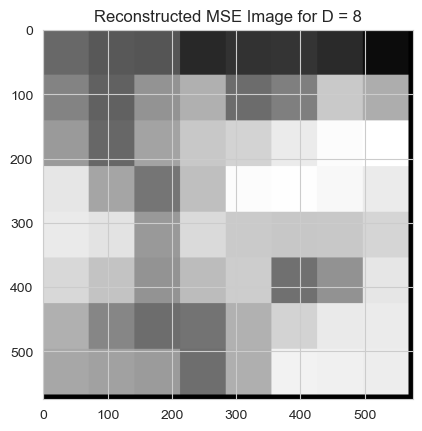

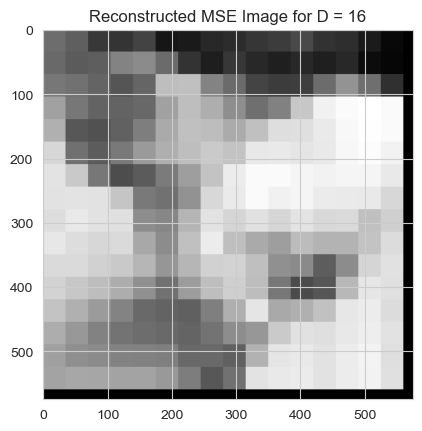

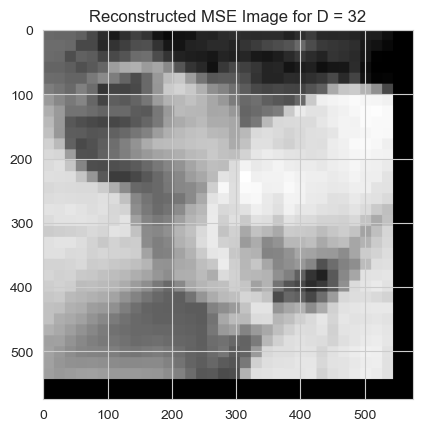

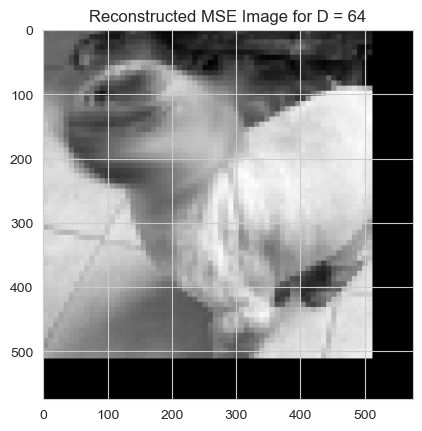

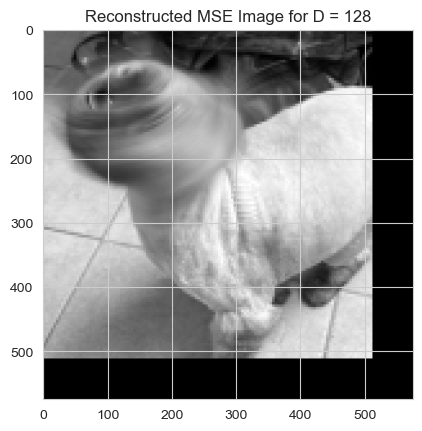

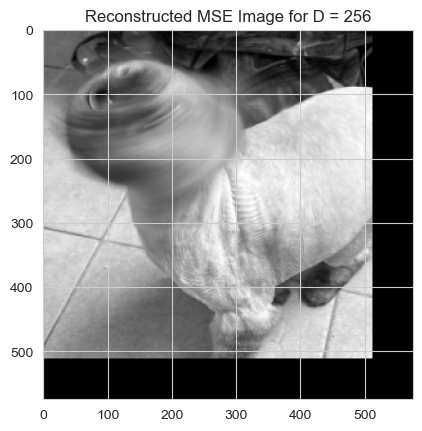

NameError: name 'mad_reconstructed_images' is not defined

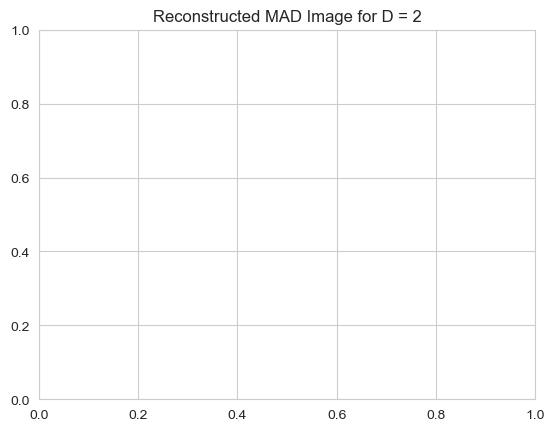

In [411]:
for i in range(8):
    plt.title("Reconstructed MSE Image for D = "+str(2**(i+1)))
    plt.imshow(mse_reconstructed_image[i], cmap='gray')
    plt.grid(False)
    plt.show()

for i in range(8):
    plt.title("Reconstructed MAD Image for D = "+str(2**(i+1)))
    plt.imshow(mad_reconstructed_images[i], cmap='gray')
    plt.show()